#  Appleの株価をLSTMで予測
過去10日間の株価の終値から、翌日の株価を予測

In [3]:
import datetime 
import pandas as pd
import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader
import sklearn
import sklearn.linear_model
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import fix_yahoo_finance as yf
yf.pdr_override()
pd.core.common.is_list_like = pd.api.types.is_list_like


Using TensorFlow backend.


In [4]:
# データウェアハウス
import fix_yahoo_finance as yf
yf.pdr_override()
pd.core.common.is_list_like = pd.api.types.is_list_like

df_aapl = pandas_datareader.data.get_data_yahoo('AAPL',  start= '2014-01-01')

[*********************100%***********************]  1 of 1 downloaded


In [5]:
df=pd.DataFrame(df_aapl)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,79.167145,80.182854,79.142860,80.145714,68.448830,55771100
2014-01-02,79.382858,79.575714,78.860001,79.018570,67.486176,58671200
2014-01-03,78.980003,79.099998,77.204285,77.282860,66.003777,98116900
2014-01-06,76.778572,78.114288,76.228569,77.704285,66.363701,103152700
2014-01-07,77.760002,77.994286,76.845711,77.148575,65.889114,79302300
2014-01-08,76.972855,77.937141,76.955711,77.637146,66.306381,64632400
2014-01-09,78.114288,78.122856,76.478569,76.645714,65.459641,69787200
2014-01-10,77.118568,77.257141,75.872856,76.134285,65.022835,76244000
2014-01-13,75.701431,77.500000,75.697144,76.532860,65.363243,94623200


In [6]:
#データ標準化
df['close'] = preprocessing.scale(df['Close'])
df = df.loc[:, ['close']]

In [8]:
#訓練、テストデータの作成
maxlen = 10
X, Y = [], []
for i in range(maxlen,len(df)):
    X.append(df[['close']].iloc[i-maxlen : i].as_matrix())
    Y.append(df[['close']].iloc[i].as_matrix())
X=np.array(X)
Y=np.array(Y)

# 訓練用のデータと、テスト用のデータに分ける
n_train = int(len(df) * 0.8)
n_test = len(df) - n_train
X_train, X_test, y_train, y_test = \
                     train_test_split(X, Y, test_size=n_test, shuffle = False) 

# 隠れ層の数などを定義
n_in = 1 # len(X[0][0])
n_out = 1 # len(Y[0])
n_hidden = 500

#KerasのLSTMモデルを構築
model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None, maxlen, n_in),
               kernel_initializer='random_uniform',
               return_sequences=False))
model.add(Dense(n_in, kernel_initializer='random_uniform'))
model.add(Activation("linear"))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss = "mean_squared_error", optimizer=opt)

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
hist = model.fit(X_train, y_train, batch_size=maxlen, 
                        epochs=50,callbacks=[early_stopping])

/Users/okunagatatsuya/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/okunagatatsuya/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch 1/50
945/945 [==============================] - 5s 5ms/step - loss: 0.0413
Epoch 2/50
945/945 [==============================] - 4s 5ms/step - loss: 0.0095
Epoch 3/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0100
Epoch 4/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0084
Epoch 5/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0066
Epoch 6/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0064
Epoch 7/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0054
Epoch 8/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0059
Epoch 9/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0051
Epoch 10/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0056
Epoch 11/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0040
Epoch 12/50
945/945 [==============================] - 4s 4ms/step - loss: 0.0037
Epoch 13/50
945/945 [====

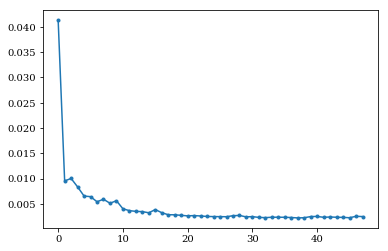

In [9]:
# 損失のグラフ化
loss = hist.history['loss']
epochs = len(loss)
plt.rc('font', family='serif')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
plt.show()

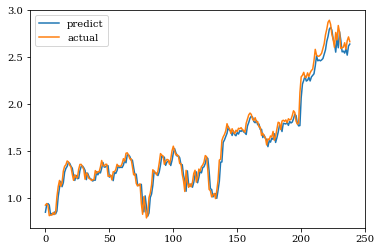

In [10]:
# 予測結果
predicted = model.predict(X_test)
result = pd.DataFrame(predicted)
result.columns = ['predict']
result['actual'] = y_test
result.plot()
plt.show()